In [1]:
%matplotlib widget
import virtuosopy as vp
import numpy as np

# Create, simulate, and verify an adder

In [2]:
sch = vp.Schematic('vp_demonstration', 'AP_ADD_1', overwrite=True)

# store the nmoses and pmoses so we can reference them for routing wires
pmoses = []
nmoses = []

# creates a stack of nmoses and pmoses
def stack(sch, pos, np, nn, labels, stack_num, width_iter):
    ps = []
    ns = []

    if np > 0:    
        p = sch.create_instance('analogLib', 'pmos4', pos, f'pm{stack_num}_0')
        sch.create_wire('route', [p.pins.G,p.pins.B], labels[0])
        p['model'] = 'pfet'
        p['l'] = '10n'
        p['w'] = next(width_iter)
        ps.append(p)
        for i in range(1, np):
            p = sch.create_instance('analogLib', 'pmos4', ([ps[-1].pins.D, 'S'], 'below'), f'pm{stack_num}_{i}')
            sch.create_wire('route', [p.pins.G,p.pins.B], labels[i])
            p['model'] = 'pfet'
            p['w'] = next(width_iter)
            ps.append(p)

        sch.create_wire('route', [ps[0].pins.S, ps[0].pins.S.pos + [0.,2.]], 'vdd!')
    
    if nn > 0:
        n = sch.create_instance('analogLib', 'nmos4', ([ps[-1].pins.D, 'D'], 'below'), f'nm{stack_num}_{0}')
        sch.create_wire('route', [n.pins.G,n.pins.B], labels[np])
        n['model'] = 'nfet'
        n['l'] = '10n'
        n['w'] = next(width_iter)
        ns.append(n)
        for i in range(1, nn):
            n = sch.create_instance('analogLib', 'nmos4', ([ns[-1].pins.S, 'D'], 'below'), f'nm{stack_num}_{i}')
            sch.create_wire('route', [n.pins.G,n.pins.B], labels[i+np])
            n['model'] = 'nfet'
            n['w'] = next(width_iter)
            ns.append(n)

        sch.create_wire('route', [ns[-1].pins.S, ns[-1].pins.S.pos + [0.,-2.]], 'gnd!')


    return ps, ns

w = np.random.uniform(low=14e-9, high=500e-9, size=17)
w = [f'{wi:.3}' for wi in w]

width_iter = iter(w)
        
# create the 5 stacks
ps, ns = stack(sch, [0.,0.], 2 , 2, ['B', 'Cin', 'Cin', 'A'], 0, width_iter)
pmoses += ps
nmoses += ns

ps, ns = stack(sch, [10.,0.], 2 , 1, ['B', 'A', 'B'], 1, width_iter)
pmoses += ps
nmoses += ns

ps, ns = stack(sch, [20.,0.], 2 , 2, ['A', 'Cout_b', 'Cout_b', 'Cin'], 2, width_iter)
pmoses += ps
nmoses += ns

sch.create_wire('route', [pmoses[1].pins.D,pmoses[-1].pins.G], 'Cout_b')

ps, ns = stack(sch, [30.,0.], 1, 0, ['B'], 3, width_iter)
pmoses += ps
nmoses += ns

sch.create_wire('route', [pmoses[-1].pins.D,pmoses[-3].pins.D])

ps, ns = stack(sch, [40.,-15.], 1, 3, ['Cin', 'Cin', 'A', 'B'], 4, width_iter)
pmoses += ps
nmoses += ns

sch.create_wire('route', [nmoses[-5].pins.D,pmoses[-1].pins.D], 'Sum_b')

# create vdd
V_VDD_0V800 = sch.create_vsource('vdc', [-15., -20.], 'V_VDD_0V800', 'vdd!', n_name='gnd!')
V_VDD_0V800['vdc'] = '0.8'

# add pins
pin_A = sch.create_pin('A', 'input', (nmoses[1].pins.G, 'left', 2))
pin_B = sch.create_pin('B', 'input', (pmoses[0].pins.G, 'left', 2))
pin_Cin = sch.create_pin('Cin', 'input', (pmoses[1].pins.G, 'left', 2))

pin_Cout_b = sch.create_pin('Cout_b', 'output', (pmoses[5].pins.G, 'above', 8), 'R270')
pin_Sum_b = sch.create_pin('Sum_b', 'output', (pmoses[-1].pins.D, 'right', 2))

# add capacitors
cout_cap = sch.create_instance('analogLib', 'cap', [-15., -40.], 'cout_cap')
cout_cap['c'] = '1f'
sch.create_wire('route', [cout_cap.pins.PLUS, cout_cap.pins.PLUS.pos + [0., 2.]], 'Cout_b' )
sch.create_wire('route', [cout_cap.pins.MINUS, cout_cap.pins.MINUS.pos + [0., -2.]], 'gnd!' )

sum_b_cap = sch.create_instance('analogLib', 'cap', [-15., -55.], 'sum_b_cap')
sum_b_cap['c'] = '1f'
sch.create_wire('route', [sum_b_cap.pins.PLUS, sum_b_cap.pins.PLUS.pos + [0., 2.]], 'Sum_b' )
sch.create_wire('route', [sum_b_cap.pins.MINUS, sum_b_cap.pins.MINUS.pos + [0., -2.]], 'gnd!' )

if sch.save():
    print('error saving')
else:
    print('Save successful')



Save successful


HBox()

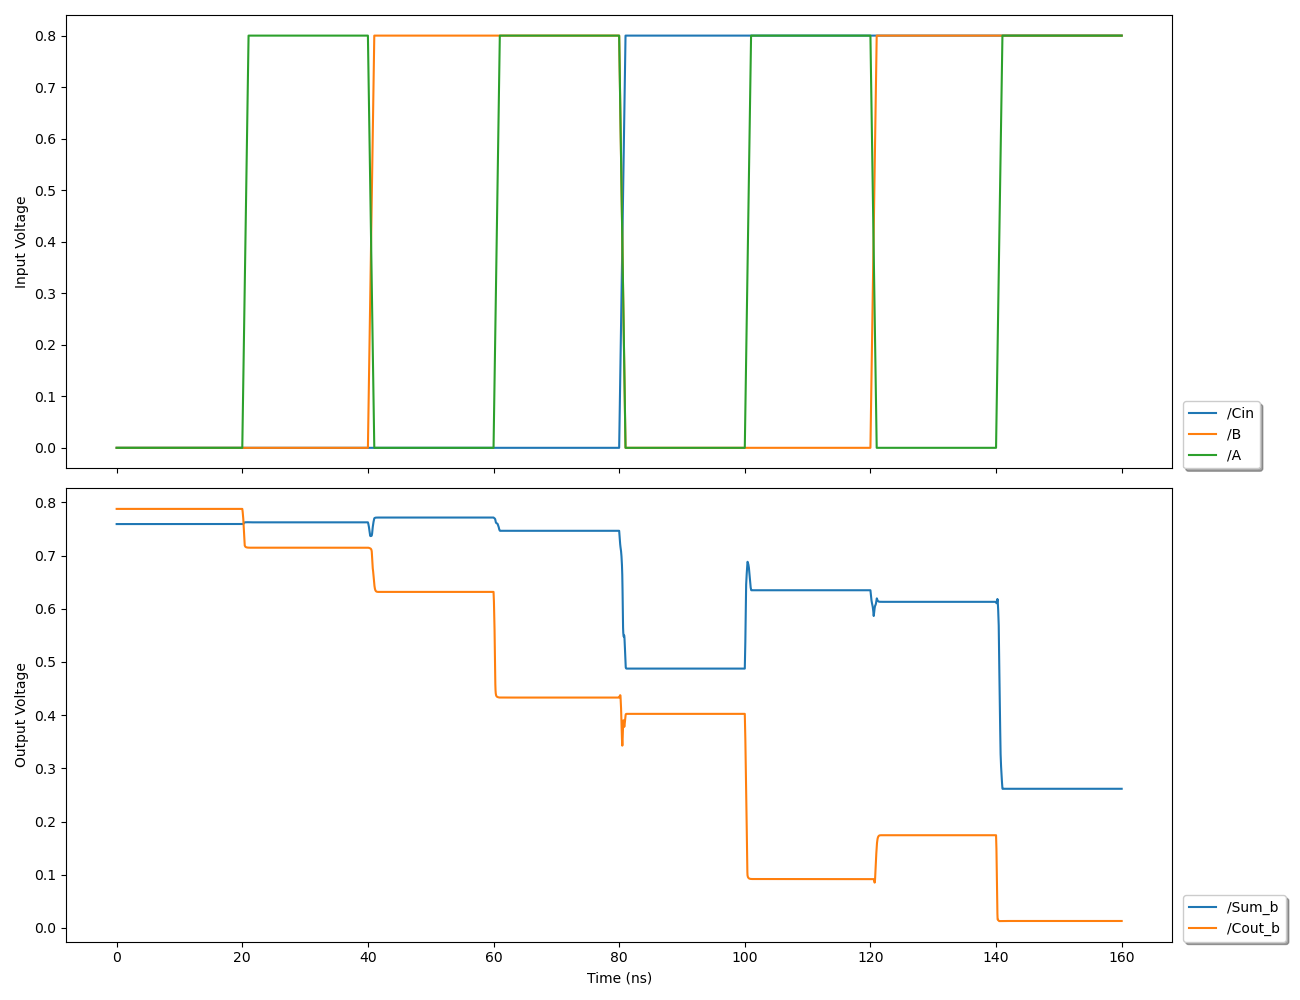

In [3]:
# setup stimuli
period = 20e-9

A_stim =    '01010101'
B_stim =    '00110011'
Cin_stim =  '00001111'

stims = {}
stims['A'] = {'type' : 'bit', 'data' : A_stim}

stims['B'] = {'type' : 'bit', 'data' : B_stim}

stims['Cin'] = {'type' : 'bit', 'data' : Cin_stim}

model_files = ['../model/FinFET/14nfet.pm', '../model/FinFET/14pfet.pm']

s = vp.Simulator(f'{len(A_stim) * period}', sch, model_files)

s.bit_stim_defaults = {'val0' : 0, 'val1' : 0.8, 'period' : 20e-9, 'rise' : 1e-9, 'fall' : 1e-9}
s.apply_stims(stims)

s.track_net('Cin', sig_type='Input Voltage')
s.track_net('B', sig_type='Input Voltage')
s.track_net('A', sig_type='Input Voltage')

s.track_net('Sum_b', sig_type='Output Voltage')
s.track_net('Cout_b', sig_type='Output Voltage')

s.run()
s.plot()

In [4]:
sample_times = np.arange(period/2, period * len(A_stim), period)

t = s.x[0]

print('Time(ns)\tA\tB\tCin\tSum\tCout')
for s_t in sample_times:
    # get the index in the waves for this sample time
    index = (np.abs(t - s_t).argmin())
    

    if s.waves['/Cin']['y'][0][index] >= 0.4:
        cin = 1
    else:
        cin = 0

    if s.waves['/A']['y'][0][index] >= 0.4:
        a = 1
    else:
        a = 0

    if s.waves['/B']['y'][0][index] >= 0.4:
        b = 1
    else:
        b = 0

    if s.waves['/Sum_b']['y'][0][index] >= 0.4:
        sum_out = 0
    else:
        sum_out = 1

    if s.waves['/Cout_b']['y'][0][index] >= 0.4:
        cout = 0
    else:
        cout = 1
     
    sum_correct = (a ^ b ^ cin)
    cout_correct = (a ^ b) & cin | (a & b)
    
    print(f'{int(s_t*1e9)}\t\t{a}\t{b}\t{cin}\t{sum_out}({sum_correct})\t{cout}({cout_correct})')
    
    



Time(ns)	A	B	Cin	Sum	Cout
10		0	0	0	0(0)	0(0)
30		1	0	0	0(1)	0(0)
50		0	1	0	0(1)	0(0)
70		1	1	0	0(0)	0(1)
90		0	0	1	0(1)	0(0)
110		1	0	1	0(0)	1(1)
130		0	1	1	0(0)	1(1)
150		1	1	1	1(1)	1(1)
